In [ ]:
import sys, os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import basic, utils, mri_stats, stats
from stats_tools import vis as svis
import numpy as np
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from access_sif_data import load_data_tools as ld
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime as dt
import datetime
%matplotlib inline
plt.style.use('ggplot')
import importlib
importlib.reload(svis)
import matplotlib.dates as mdates
params = {'figure.dpi':350,
        'legend.fontsize': 18,#
        'figure.figsize': [8, 5],
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
mpl.rcParams.update(params) 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

## AcquisitionContrast Column can be dropped

In [82]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
# dfc = utils.load_scan_csv(join(table_dir, 'scan_tables','scan_after_sq_pred_dst.csv'))
with open(join(table_dir, 'scan_tables','scan_after_sq_pred_dst_nos_date.pkl'), 'rb') as f:
    dfc = pickle.load(f)

In [83]:
dfc['positive_scan'] = 0
dfc.loc[dfc.days_since_test>=-3, 'positive_scan'] = 1

## Drop missing dates from 2020

In [84]:
dfcc = dfc[(dfc['2019']==1)|(~dfc.InstanceCreationDate.isna())]

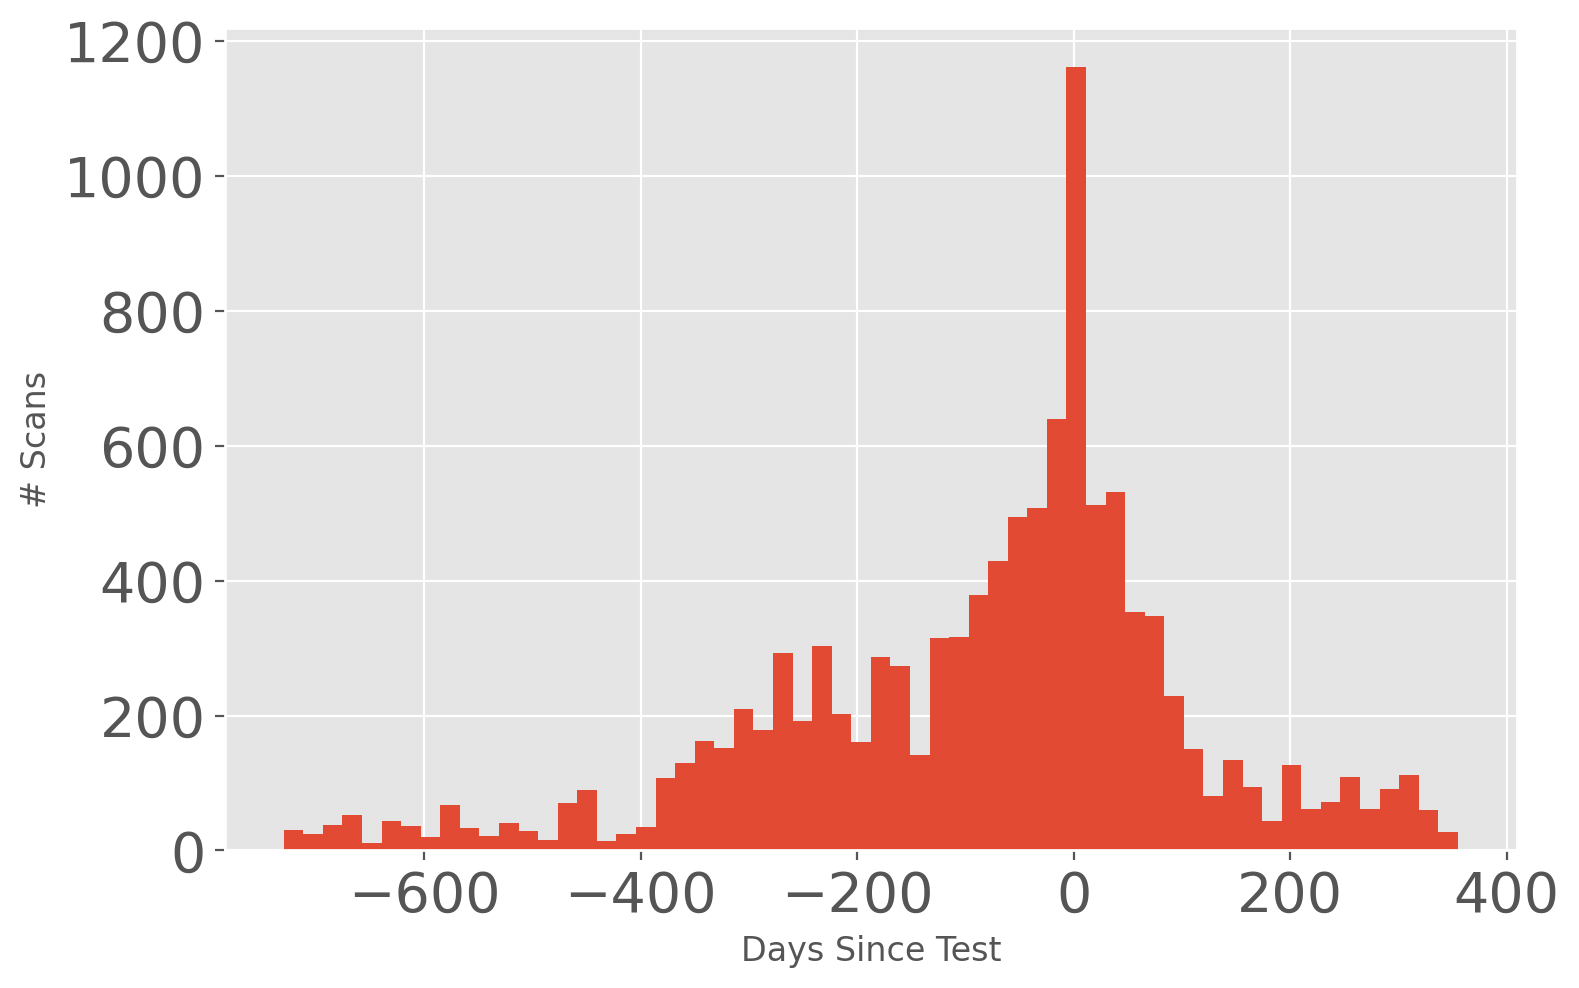

In [85]:
fig,ax = plt.subplots()
dfc.days_since_test.hist(ax=ax, bins=60)
ax.set_xlabel('Days Since Test')
ax.set_ylabel('# Scans')
fig.tight_layout()
fig.savefig(join(fig_dir, 'basic_stats','days_since_test.png'),dpi=350)

## Number of positive and negative patients by modality

Text(-0.1, 24381, '24081')

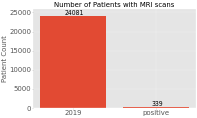

In [32]:
plt.rcParams["figure.dpi"] = 20
labels = ['2019', 'positive']
pos_mask = dfc.Positive==1
pos_pat_count = dfc['PatientID'][pos_mask].nunique()
neg_pat_count = dfc['PatientID'][~pos_mask].nunique()
counts = np.array([neg_pat_count, pos_pat_count])
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig, ax = svis.bar(labels, counts, kwargs=kwargs)
ax.text(1-.05, pos_pat_count+300, pos_pat_count, fontsize=22)
ax.text(0-.1, neg_pat_count+300, neg_pat_count, fontsize=22)

# Acquisition date

## For each volume

In [86]:
dft = dfcc[dfcc.InstanceCreationDate!=dt(2018,1,1)]
dftp = dft[dft.positive_scan==1]
dftn = dft[dft.positive_scan==0]
dftp['InstanceCreationDate'] = dftp['InstanceCreationDate'].apply(
    lambda x: dt(int(x.year), int(x.month), 1))
dftn['InstanceCreationDate'] = dftn['InstanceCreationDate'].apply(
    lambda x: dt(int(x.year), int(x.month), 1))

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [87]:
dftp = pd.DataFrame(dftp.groupby(['InstanceCreationDate']).SeriesInstanceUID.size())
dftn = pd.DataFrame(dftn.groupby(['InstanceCreationDate']).SeriesInstanceUID.size())
dftp.head()

,SeriesInstanceUID
InstanceCreationDate,
2020-03-01,36
2020-04-01,188
2020-05-01,237
2020-06-01,332
2020-07-01,126


In [88]:
dftp = dftp[(dftp.index>=dt(2018,11,1))&\
     (dftp.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')
dftn = dftn[(dftn.index>=dt(2018,11,1))&\
     (dftn.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')

In [89]:
dftp2 = dftp[(dftp.index>=dt(2020,1,1))&\
     (dftp.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')
dftn2 = dftn[(dftn.index>=dt(2020,1,1))&\
     (dftn.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


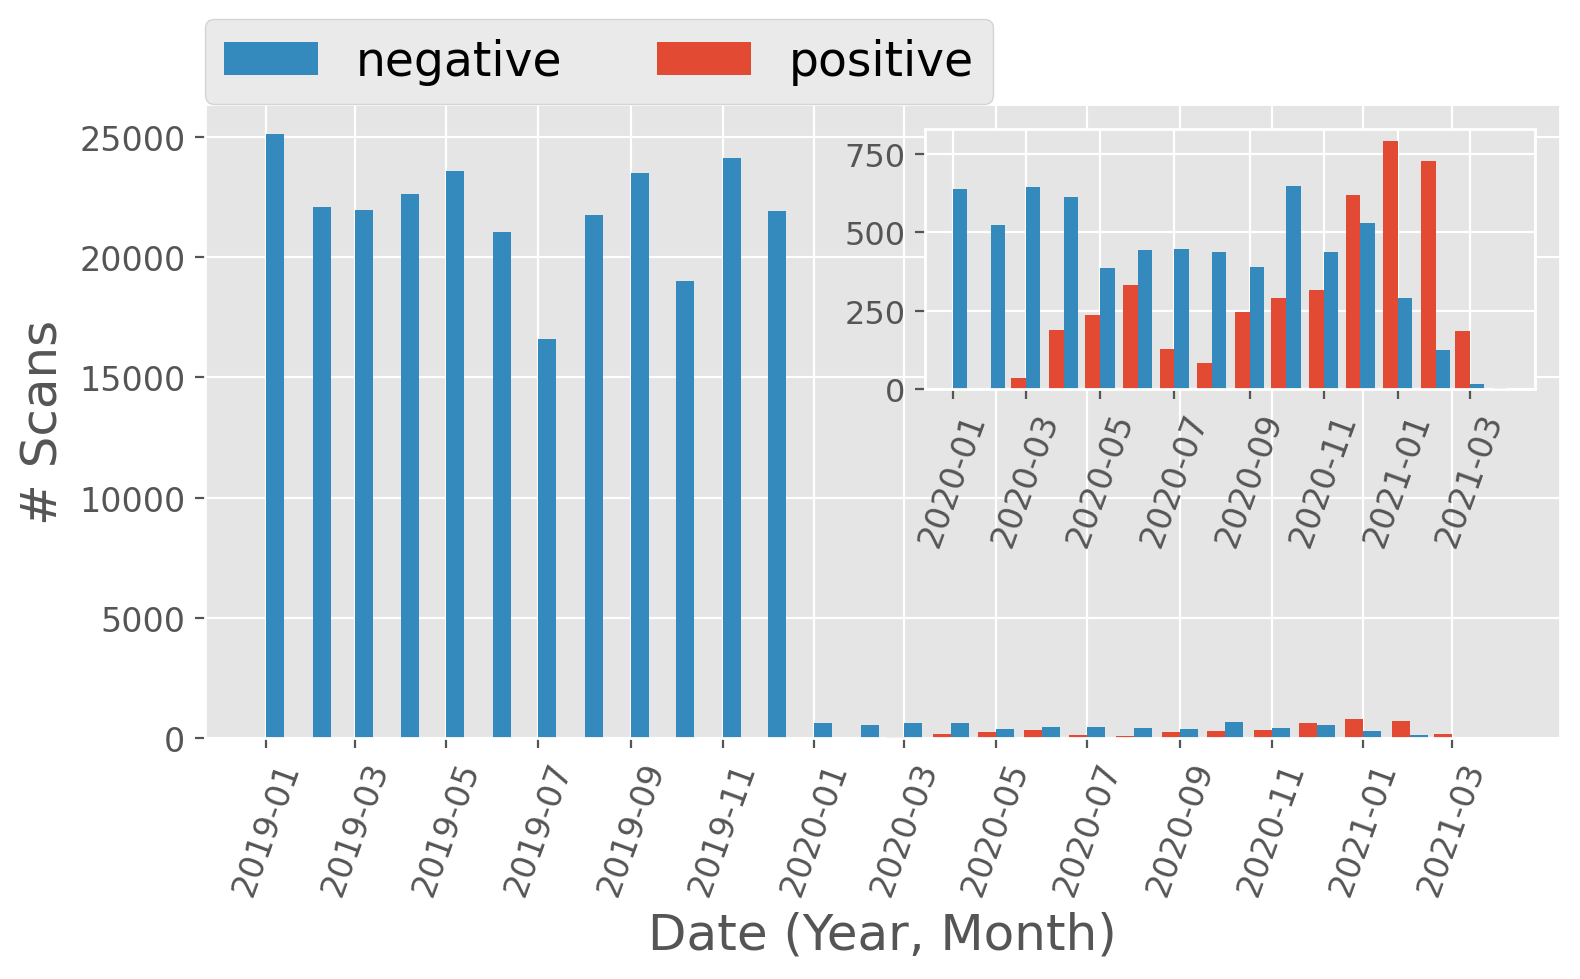

In [90]:
fig, ax = plt.subplots()
plt.rcParams["figure.dpi"] = 200

ax.bar(dftn.index+datetime.timedelta(6), dftn.SeriesInstanceUID, 
    width=12, color=colors[1],label='negative')
ax.bar(dftp.index-datetime.timedelta(6), dftp.SeriesInstanceUID, width=12, color=colors[0],
    label='positive')
axins = inset_axes(ax,
                    width="45%", # width = 30% of parent_bbox
                    height=1.3, # height : 1 inch
                    loc=1)
                              
axins.bar(dftn2.index+datetime.timedelta(6), dftn2.SeriesInstanceUID, width=12, color=colors[1], )
axins.bar(dftp2.index-datetime.timedelta(6), dftp2.SeriesInstanceUID, width=12, color=colors[0],)

axins.xaxis.set_major_locator(mdates.MonthLocator())
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axins.tick_params(axis='x', which='major',  rotation=70, labelsize=12)
axins.tick_params(axis='y', which='major', labelsize=11.5,)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', which='major', labelsize=12, rotation=70)
ax.tick_params(axis='y', which='major', labelsize=12,)
x_ticks = axins.get_xticks()
_ = axins.set_xticks(x_ticks[::2])

x_ticks = ax.get_xticks()
_ = ax.set_xticks(x_ticks[1:-2:2])
ax.set_ylabel('# Scans', fontsize=18)
ax.set_xlabel('Date (Year, Month)', fontsize=18)
ax.legend(ncol=2, loc=(0,1), fontsize=17)
fig.tight_layout()
fig.savefig(join(fig_dir, 'basic_stats','ac_date_pos_neg.png'),dpi=350)

## For each study

In [123]:
importlib.reload(mri_stats)

<module 'utilities.mri_stats' from 'c:\\Users\\kiril\\Thesis\\CoBra\\cobra\\utilities\\mri_stats.py'>

In [100]:
dfccc = dfcc[~dfcc.InstanceCreationDate.isna() & ~dfcc.InstanceCreationTime.isna()]

In [115]:
dfccc.loc[dfccc.index,'DateTime'] = dfccc.apply(lambda x: 
dt(x.InstanceCreationDate.year, 
    x.InstanceCreationDate.month,
    x.InstanceCreationDate.day,
    int(str(x.InstanceCreationTime)[:2]),
    int(str(x.InstanceCreationTime)[3:5]),
    0), axis=1
     )

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [124]:
df_sorted = dfccc.groupby('PatientID').apply(
        lambda x: (x.sort_values(by=['DateTime'], ascending=True)))
df_studies = mri_stats.get_studies_df(df_sorted, threshold=1)
df_studies.to_csv(f"{table_dir}/studies_clean.csv", index=False, header=True)

KeyboardInterrupt: 

In [122]:
df_studies.head()

,PatientID,StudyNum,DateTimeStart,NumVolumes
0,0004c6f76c29c48fbdf035510d8633e8,0,2019-10-17 11:31:00,2
1,000c732e3d06653616002de65cddebe5,0,2019-10-01 14:53:00,3
2,000fb4fc0c026069cf767ecb52bc996f,0,2019-11-30 11:30:00,13
3,0010c0a092cbfc040a47f4318dfaa451,0,2019-10-01 15:40:00,3
4,001110dc40c217c554ee0700a64cef9f,0,2019-05-10 13:48:00,9
5,001110dc40c217c554ee0700a64cef9f,1,2019-05-10 18:20:00,1
6,0014ca78c73b7b83269bf94c7d35446c,0,2019-06-19 13:31:00,1
7,001511919d977c1c744f00ccf236e610,0,2019-05-08 13:26:00,10
8,001c542e7d63aa3bfb8591fb5d58a3e4,0,2019-11-11 19:12:00,4
9,00200f5fa205f29c3c159a1fca08151d,0,2019-12-13 10:42:00,14


In [119]:
df_studies = pd.read_csv(f"{table_dir}/studies_clean.csv", 
    converters={'DateTimeStart':utils.date_time_converter})
df_studies_p = df_studies[df_studies.Positive==1]
df_studies_n = df_studies[df_studies.Positive==0] 

AttributeError: 'DataFrame' object has no attribute 'Positive'

## Studies over time

In [17]:
df_studies_n = df_studies[df_studies.PatientID.isin(dfc[dfc.Positive==0].PatientID)]
df_studies_p = df_studies[df_studies.PatientID.isin(dfc[dfc.Positive==1].PatientID)]

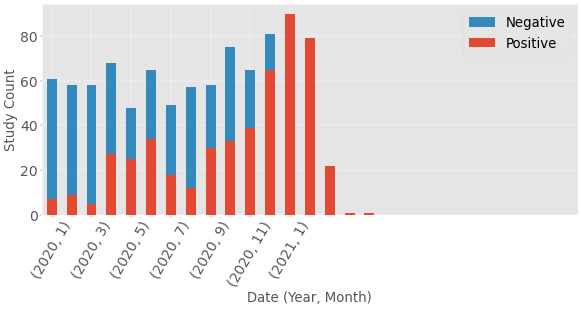

In [18]:
fig, ax = svis.plot_decorator(df_studies_n.groupby([df_studies_n["DateTimeStart"].dt.year, \
    df_studies_n["DateTimeStart"].dt.month]).DateTimeStart.count().plot, 
    figsize=(15,8),
    plot_func_kwargs={'kind':'bar','label':'Negative', 
        'color':svis.Color_palette(0)[1],} ,
    kwargs={'xtickparams_rot':60, 'ylabel':'Study Count',
        'ylabel_fs':24,
    })
ax = df_studies_p.groupby([df_studies_p["DateTimeStart"].dt.year, \
    df_studies_p["DateTimeStart"].dt.month]).DateTimeStart.count().plot(kind="bar", 
    color=svis.Color_palette(0)[0], ax=ax, label='Positive')
ax.tick_params(axis='x', which='major', rotation=60)
ax.set_xlabel('Date (Year, Month)', fontsize=24)
ax.legend(fontsize=24)
x_ticks = ax.get_xticks()

# Set xtick locations to the values of the array `x_ticks`
ax.set_xticks(x_ticks[:-3:2])

ax.set_xlim(-.5, 26.5)
fig.savefig(join(fig_dir, 'basic_stats','year_month_studies_no_other'),dpi=100)